# Coin Toss (MLE, MAP, Fully Bayesian) in TF Probability

- toc: true 
- badges: true
- comments: true
- author: Nipun Batra
- categories: [ML, TFP, TF]

### Basic Imports

In [1]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import functools
import seaborn as sns
import tensorflow_probability as tfp
import pandas as pd

tfd = tfp.distributions
tfl = tfp.layers
tfb = tfp.bijectors

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback

sns.reset_defaults()
sns.set_context(context="talk", font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
distribution = tfd.Bernoulli(probs=0.75)

dataset_10 = distribution.sample(10)
print(dataset_10.numpy())
mle_estimate_10 = tf.reduce_mean(tf.cast(dataset_10, tf.float32))
tf.print(mle_estimate_10)

[1 1 1 1 1 0 1 1 0 1]
0.8


In [3]:
dataset_large = distribution.sample(100000)

mle_estimate = {}
for dataset_size in [10, 50, 100, 500, 1000, 10000, 100000]:
    mle_estimate[dataset_size] = tf.reduce_mean(
        tf.cast(dataset_large[:dataset_size], tf.float32)
    )
tf.print(mle_estimate)

{10: 0.4,
 50: 0.7,
 100: 0.74,
 500: 0.738,
 1000: 0.741,
 10000: 0.7496,
 100000: 0.75038}


In [4]:
theta = tf.Variable(0.1)
fit = tfd.Bernoulli(probs=theta)

fit.log_prob(dataset_10)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-2.3025851 , -2.3025851 , -2.3025851 , -2.3025851 , -2.3025851 ,
       -0.10536052, -2.3025851 , -2.3025851 , -0.10536052, -2.3025851 ],
      dtype=float32)>

In [5]:
distribution.log_prob(dataset_10)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-0.2876821, -0.2876821, -0.2876821, -0.2876821, -0.2876821,
       -1.3862944, -0.2876821, -0.2876821, -1.3862944, -0.2876821],
      dtype=float32)>

In [6]:
-tf.reduce_mean(fit.log_prob(dataset_10))

<tf.Tensor: shape=(), dtype=float32, numpy=1.8631403>

In [7]:
dataset = dataset_10


def loss():
    return -tf.reduce_mean(fit.log_prob(dataset))

In [8]:
fit.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.1>,)

In [9]:
trace_fn = lambda traceable_quantities: {
    "loss": traceable_quantities.loss,
    "theta": theta,
}

num_steps = 150

In [10]:
trace = tfp.math.minimize(
    loss_fn=loss,
    num_steps=num_steps,
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    trace_fn=trace_fn,
)

In [11]:
theta

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.77280205>

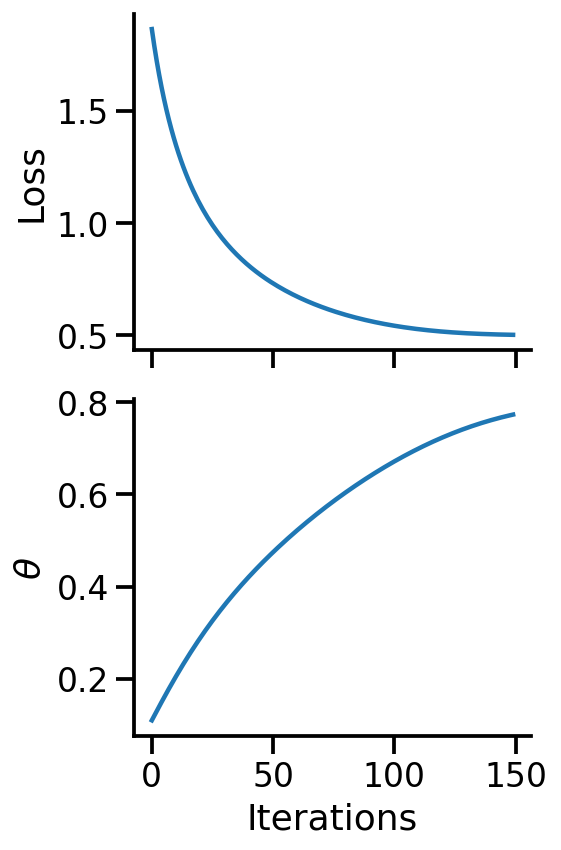

In [12]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(4, 6))
ax[0].plot(range(num_steps), trace["loss"])
ax[1].plot(range(num_steps), trace["theta"])
sns.despine()
ax[1].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel(r"$\theta$")
fig.tight_layout()

In [13]:
@tf.function
def loss_and_grads(fit):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(fit.log_prob(dataset))
    return loss, tape.gradient(loss, fit.trainable_variables)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


theta = tf.Variable(0.1)
fit = tfd.Bernoulli(probs=theta)


for i in range(num_steps):
    loss, grads = loss_and_grads(fit)
    optimizer.apply_gradients(zip(grads, fit.trainable_variables))

In [14]:
fit.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.77280205>,)

#### MAP

In [15]:
def coin_toss_uniform_model():
    theta = yield tfp.distributions.JointDistributionCoroutine.Root(
        tfp.distributions.Uniform(low=0.0, high=1.0, name="Theta")
    )

    coin = yield tfp.distributions.Bernoulli(probs=tf.ones(100) * theta, name="Coin")

In [16]:
coin_toss_uniform_model

<function __main__.coin_toss_uniform_model()>

In [17]:
model_joint_uniform = tfp.distributions.JointDistributionCoroutineAutoBatched(
    lambda: coin_toss_uniform_model(), name="Original"
)

In [18]:
model_joint_uniform

<tfp.distributions.JointDistributionCoroutineAutoBatched 'Original' batch_shape=[] event_shape=StructTuple(
  Theta=[],
  Coin=[100]
) dtype=StructTuple(
  Theta=float32,
  Coin=int32
)>

In [19]:
model_joint_uniform.log_prob(model_joint_uniform.sample())

<tf.Tensor: shape=(), dtype=float32, numpy=-44.148933>

In [20]:
def uniform_model(dataset):
    num_datapoints = len(dataset)
    theta = yield tfp.distributions.JointDistributionCoroutine.Root(
        tfp.distributions.Uniform(low=0.0, high=1.0, name="Theta")
    )
    coin = yield tfp.distributions.Bernoulli(probs=tf.ones(num_datapoints) * theta, name="Coin")

In [21]:
concrete_uniform_model = functools.partial(uniform_model, dataset = dataset_10)

model = tfd.JointDistributionCoroutineAutoBatched(concrete_uniform_model)

In [22]:
model.sample()

StructTuple(
  Theta=<tf.Tensor: shape=(), dtype=float32, numpy=0.6621648>,
  Coin=<tf.Tensor: shape=(10,), dtype=int32, numpy=array([1, 0, 1, 1, 1, 1, 1, 1, 1, 0], dtype=int32)>
)

In [23]:


th = tf.Variable(0.4)

target_log_prob_fn = lambda th: model.log_prob((th, dataset_10))
target_log_prob_fn

<function __main__.<lambda>(th)>

In [24]:
trace = tfp.math.minimize(
    lambda: -target_log_prob_fn(th),
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    #trace_fn=trace_fn,
    num_steps=200,
)

In [25]:
th

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.80001694>

In [26]:
mle_estimate_10

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [27]:
tfp.distributions.Beta(concentration0=40, concentration1 = 10,  name="Theta").sample(100)

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([0.22182319, 0.13401756, 0.23965973, 0.17444858, 0.14213562,
       0.28528732, 0.21859348, 0.2030608 , 0.16903868, 0.16523781,
       0.267017  , 0.27806625, 0.28052706, 0.3048697 , 0.1721505 ,
       0.27562535, 0.25764838, 0.17619318, 0.16079605, 0.16251576,
       0.2070497 , 0.2318581 , 0.22189423, 0.22807145, 0.13673237,
       0.22214967, 0.19596058, 0.10157332, 0.07999253, 0.26003855,
       0.14553878, 0.23743597, 0.10411   , 0.21954453, 0.18285999,
       0.20024276, 0.18601274, 0.19060922, 0.12598696, 0.20128909,
       0.2878245 , 0.21054542, 0.2071062 , 0.24102312, 0.11416852,
       0.18712431, 0.3273607 , 0.24691054, 0.18499938, 0.15327194,
       0.2318373 , 0.22768235, 0.1324633 , 0.22745433, 0.19081199,
       0.21144053, 0.24464151, 0.18957576, 0.3140406 , 0.27400783,
       0.25298724, 0.24339008, 0.18338221, 0.20414814, 0.19388673,
       0.20810917, 0.21882814, 0.18017116, 0.20921457, 0.2371721 ,
       0.18695

(array([ 13.,  35.,  87., 156., 218., 221., 144.,  91.,  28.,   7.]),
 array([0.35856122, 0.3872732 , 0.4159852 , 0.44469717, 0.47340918,
        0.50212115, 0.5308331 , 0.5595451 , 0.58825713, 0.6169691 ,
        0.6456811 ], dtype=float32),
 <BarContainer object of 10 artists>)

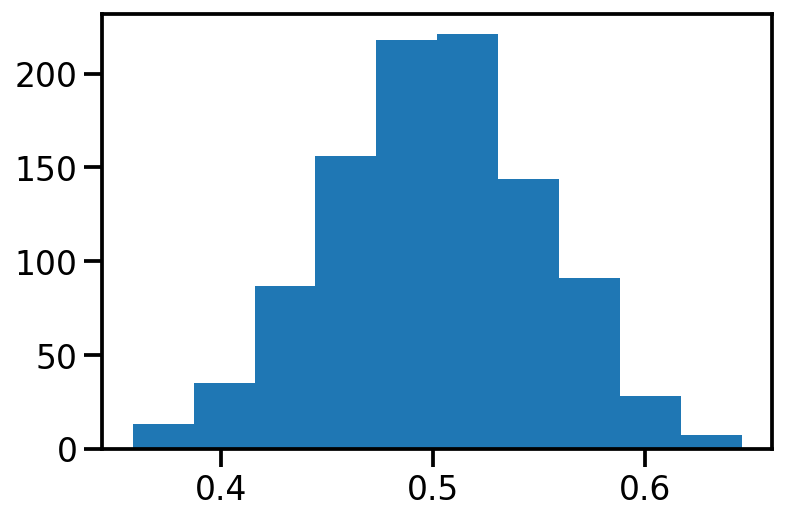

In [28]:
plt.hist(tfp.distributions.Beta(concentration0=50, concentration1 = 50,  name="Theta").sample(1000).numpy())

In [29]:
def beta_prior_model(dataset):
    num_datapoints = len(dataset)
    theta = yield tfp.distributions.JointDistributionCoroutine.Root(
        tfp.distributions.Beta(concentration0=40, concentration1 = 10,  name="Theta")
    )
    coin = yield tfp.distributions.Bernoulli(probs=tf.ones(num_datapoints) * theta, name="Coin")

In [30]:
concrete_beta_prior_model = functools.partial(beta_prior_model, dataset = dataset_10)

In [31]:
model_2 = tfd.JointDistributionCoroutineAutoBatched(concrete_beta_prior_model)

In [32]:
model_2.sample()

StructTuple(
  Theta=<tf.Tensor: shape=(), dtype=float32, numpy=0.17273995>,
  Coin=<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0], dtype=int32)>
)

In [33]:
th = tf.Variable(0.2)

target_log_prob_fn = lambda th: model_2.log_prob((th, dataset_10))
target_log_prob_fn

<function __main__.<lambda>(th)>

In [34]:
trace = tfp.math.minimize(
    lambda: -target_log_prob_fn(th),
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    #trace_fn=trace_fn,
    num_steps=200,
)

In [35]:
th

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.29310602>